In [1]:
import torch
import torchvision.datasets
import torchvision.models
import torchvision.transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, ConcatDataset
from pathlib import Path
import numpy as np
from PIL import Image, ImageOps
import os, sys, math, random, copy, time
import datasets, custom_transforms, models
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

seed = 0
split_k_folds=10
np.random.seed(seed)
torch.manual_seed(seed)

# Parameters to Change
N_CLASSES = 2
BATCH_SIZE = 4
num_epochs=50
top_cutoff_percent = 0.15 # 0.08 COVID-Net paper by Wang et al.
flag_includePneumoniaPics = False

TRAINVAL_DATA_DIR = 'G:/DanielLam/DanielCustomNetwork/DanielDataSets_Reduced_256_Rajaraman_10KFold217/trainVal/'
save_folder_name =  os.path.join("15cutoff", "VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly")


cuda:0


# Settings

In [2]:
# LOCKED
# Preprocessing settings:
interp_mode = torchvision.transforms.InterpolationMode.NEAREST
image_size_to_VGG =224 # resize input images to this size in VGG
model_name = "VGG"
num_channels = 3 # because VGG is trained on RGB images
unbias=True
limit_save_epoch_acc=0.95
limit_save_epoch_loss = 0.13

# Learning Rates
betas = (0.9,0.999)
ini_lr= 1e-3
max_layers_to_freeze = 28 # 30 means that only the last linear classifier is left to train
class_weights = torch.Tensor([1, 1100/996]) # NONCOVID, COVID



# Data Preprocessing

In [3]:
# Data Preprocessing and Transforms
# Assumes importing images as PIL Images
normalize = torchvision.transforms.Normalize(
                                [0.485, 0.456, 0.406],
                                [0.229, 0.224, 0.225])

class Equalise(object):
    # Histogram equalisation
    # Only works on PIL images
    def __init__(self, mask=None):
        self.mask = mask
    def __call__(self, image):
        return ImageOps.equalize(image, self.mask)
    
class ImageComplement(object):
    # Flip image intensities (i.e. black becomes white, white becomes black)
    # Assumes input image is a tensor with range[0,1]
    def __init__(self, probability=0.5):
        self.probability = probability
    def __call__(self, image):
        activate = np.random.uniform(0,1)
        if activate < self.probability:
            # Flip
            max_image = torch.max(image)
            min_image = torch.min(image)
            #print("min:{},max:{}".format(min_image, max_image))
            image = (image-min_image)/(max_image-min_image) # range [0,1]
            image = (1-image)*(max_image-min_image) + min_image # back to original range
        return image



train_transforms=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    custom_transforms.COVIDNetProcessing(top_cutoff_percent),
                                    torchvision.transforms.Resize(image_size_to_VGG, interpolation=interp_mode), # PIL image
                                    torchvision.transforms.CenterCrop(image_size_to_VGG),
                                    torchvision.transforms.RandomHorizontalFlip(), 
                                    torchvision.transforms.ColorJitter(brightness=0.1), # this jitters brightness
                                    torchvision.transforms.RandomAffine(degrees=10,translate=(0.1,0.1),scale=(0.9,1.1)),
                                    ImageComplement(),
                                    normalize,
                                    ])

val_transforms=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    custom_transforms.COVIDNetProcessing(top_cutoff_percent),
                                    torchvision.transforms.Resize(image_size_to_VGG, interpolation=interp_mode),
                                    torchvision.transforms.CenterCrop(image_size_to_VGG),
                                    normalize,
                                ])

# Network

In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, checkpoint_save_path = None,
                scheduler=None, is_inception=False):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    
    history_accuracy = {"train":[], "val":[]}
    history_loss = {"train":[], "val":[]}
    best_loss = 1.0
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in dataloaders.keys():
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                inputs=data["image"]
                labels=data["label"]
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                labels = labels.detach().cpu()
                preds = preds.detach().cpu()
                running_loss += loss.item() * inputs.size(0)
                # for each element in preds, check is equal to each element in labels.data
                running_corrects += torch.sum(torch.eq(preds, labels))
                #print(running_corrects)
                
            epoch_loss = running_loss / len(dataloaders[phase].sampler)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].sampler)
            print("Length of {} dataset: {}".format(phase, len(dataloaders[phase].sampler)))
            
            # Record histories
            history_accuracy[phase].append(epoch_acc)
            history_loss[phase].append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > limit_save_epoch_acc and epoch_loss < limit_save_epoch_loss and checkpoint_save_path is not None:
                best_loss = epoch_loss
                best_acc = epoch_acc
                print("Achieved current lowest loss of: {} ; accuracy = {}".format(best_loss, epoch_acc))
                best_model_wts = copy.deepcopy(model.state_dict())
                saved_checkpoint = os.path.join(checkpoint_save_path,
                             'balance[epoch_{}_loss_{:.3f}_acc_{:.3f}].pt'.format((epoch), history_loss[phase][-1],
                                                                                        history_accuracy[phase][-1]))
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': best_model_wts,
                    'optimizer_state_dict': optimizer.state_dict(),
                    'N_CLASSES': N_CLASSES,
                    'BATCH_SIZE': BATCH_SIZE,
                    'ini_lr': ini_lr,
                    'max_layers_to_freeze':max_layers_to_freeze,
                    'class_weights':class_weights,
                    'random_seed': seed
                }, saved_checkpoint)
                print("Saved checkpoint: {}".format(saved_checkpoint))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    history = {"accuracy":history_accuracy, "loss":history_loss}
    return model, history


def set_parameter_requires_grad(model, feature_extracting):
    # If feature extracting only.
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    fig = plt.gcf()
    fig.set_size_inches(18.5, 10.5)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

import datasets
import models
splits=KFold(n_splits=split_k_folds,shuffle=True,random_state=42)
foldperf={}
def pneumoniaPath(TRAINVAL_DATA_DIR,  flag_includePneumoniaPics):
    if flag_includePneumoniaPics:
        return os.path.join(TRAINVAL_DATA_DIR,"PNEUMONIA")
    else:
        return None
trainVal_dataset = datasets.Coviddataset(normal_path=os.path.join(TRAINVAL_DATA_DIR,"NORMAL"),
                                      pneumonia_path= pneumoniaPath(TRAINVAL_DATA_DIR, flag_includePneumoniaPics),
                                      covid_path=os.path.join(TRAINVAL_DATA_DIR,"COVID"),
                                      transform = None,
                                     NClasses=N_CLASSES, unbias=unbias,channels=num_channels, display_console=True)
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(trainVal_dataset)))):
    print('Fold {}'.format(fold + 1))
    
    # Subset sample from dataset
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    dl_training = DataLoader(datasets.Coviddataset(normal_path=os.path.join(TRAINVAL_DATA_DIR,"NORMAL"),
                                      pneumonia_path=pneumoniaPath(TRAINVAL_DATA_DIR, flag_includePneumoniaPics),
                                      covid_path=os.path.join(TRAINVAL_DATA_DIR,"COVID"),
                                      transform = train_transforms,
                                     NClasses=N_CLASSES, unbias=unbias,channels=num_channels, display_console=False),
                             batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=0)
    dl_validation = DataLoader(datasets.Coviddataset(normal_path=os.path.join(TRAINVAL_DATA_DIR,"NORMAL"),
                                      pneumonia_path=pneumoniaPath(TRAINVAL_DATA_DIR, flag_includePneumoniaPics),
                                      covid_path=os.path.join(TRAINVAL_DATA_DIR,"COVID"),
                                      transform = val_transforms,
                                     NClasses=N_CLASSES, unbias=unbias,channels=num_channels, display_console=False),
                             batch_size=BATCH_SIZE, sampler=test_sampler, num_workers=0)
    
    dataloaders = {'train':dl_training,'val':dl_validation}
    
    # DEBUGGING
    for phase in dataloaders.keys():
        sample = next(iter(dataloaders[phase]))
        print(sample.keys())
        out = torchvision.utils.make_grid(sample["image"])
        #imshow(out)
    
    # Model
    model = models.VGG16_Rajaraman(N_CLASSES, max_layer_to_freeze=max_layers_to_freeze, verbose=False)
    model = model.to(device)

    # Loss
    criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

    # Observe that all parameters are being optimized
    optimizer = torch.optim.Adam(model.parameters(), lr=ini_lr, betas=betas)

    # Deterministic
    torch.backends.cudnn.benchmark = False
    
    # Train model & save outputs
    checkpoint_save_path=os.path.join('checkpoints', str(N_CLASSES)+"Class", save_folder_name, 
                                      str(max_layers_to_freeze), "Fold"+str(fold + 1))
    a = Path(checkpoint_save_path)
    a.mkdir(parents=True, exist_ok=True)
    model, history = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs,
                                 checkpoint_save_path=checkpoint_save_path,
                                 is_inception=(model_name=="inception"))
    foldperf['fold{}'.format(fold+1)] = history 

None Path
RAW DATASET STATISTICS:-----------
Normal:1100, Pneumonia:0, COVID:996
2-Class Dataset Statistics:-----------
Noncovid:1100, COVID:996
Fold 1
None Path
None Path
dict_keys(['name', 'image', 'label'])
dict_keys(['name', 'image', 'label'])
Parameters total:  14715714
Parameters trainable:  2360834
Epoch 0/49
----------
Length of train dataset: 1886
train Loss: 0.3504 Acc: 0.8759
Length of val dataset: 210
val Loss: 0.1234 Acc: 0.9524
Achieved current lowest loss of: 0.12344613455345443 ; accuracy = 0.9523809523809523
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold1\balance[epoch_0_loss_0.123_acc_0.952].pt
Epoch 1/49
----------
Length of train dataset: 1886
train Loss: 0.1477 Acc: 0.9427
Length of val dataset: 210
val Loss: 0.1599 Acc: 0.9333
Epoch 2/49
----------
Length of train dataset: 1886
train Loss: 0.1420 Acc: 0.9517
Length of val dataset: 210
val Loss: 0.1094 Acc: 0.9619
Achieved current lowest loss of: 0.10935776

Length of train dataset: 1886
train Loss: 0.0658 Acc: 0.9820
Length of val dataset: 210
val Loss: 0.0574 Acc: 0.9810
Achieved current lowest loss of: 0.057432278081077405 ; accuracy = 0.9809523809523809
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold1\balance[epoch_24_loss_0.057_acc_0.981].pt
Epoch 25/49
----------
Length of train dataset: 1886
train Loss: 0.0723 Acc: 0.9793
Length of val dataset: 210
val Loss: 0.0461 Acc: 0.9905
Achieved current lowest loss of: 0.046088715593494915 ; accuracy = 0.9904761904761905
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold1\balance[epoch_25_loss_0.046_acc_0.990].pt
Epoch 26/49
----------
Length of train dataset: 1886
train Loss: 0.0479 Acc: 0.9799
Length of val dataset: 210
val Loss: 0.0480 Acc: 0.9952
Achieved current lowest loss of: 0.04804087077139123 ; accuracy = 0.9952380952380953
Saved checkpoint: checkpoints\2Class\15cutoff\VG

Length of train dataset: 1886
train Loss: 0.0535 Acc: 0.9873
Length of val dataset: 210
val Loss: 0.0848 Acc: 0.9857
Achieved current lowest loss of: 0.0848248392376676 ; accuracy = 0.9857142857142858
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold1\balance[epoch_47_loss_0.085_acc_0.986].pt
Epoch 48/49
----------
Length of train dataset: 1886
train Loss: 0.0579 Acc: 0.9820
Length of val dataset: 210
val Loss: 0.1041 Acc: 0.9857
Achieved current lowest loss of: 0.10407973216218058 ; accuracy = 0.9857142857142858
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold1\balance[epoch_48_loss_0.104_acc_0.986].pt
Epoch 49/49
----------
Length of train dataset: 1886
train Loss: 0.0461 Acc: 0.9862
Length of val dataset: 210
val Loss: 0.0659 Acc: 0.9905
Achieved current lowest loss of: 0.06587314967861081 ; accuracy = 0.9904761904761905
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16

Length of train dataset: 1886
train Loss: 0.0677 Acc: 0.9820
Length of val dataset: 210
val Loss: 0.0171 Acc: 0.9857
Achieved current lowest loss of: 0.017117656281753806 ; accuracy = 0.9857142857142858
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold2\balance[epoch_19_loss_0.017_acc_0.986].pt
Epoch 20/49
----------
Length of train dataset: 1886
train Loss: 0.0583 Acc: 0.9777
Length of val dataset: 210
val Loss: 0.1407 Acc: 0.9476
Epoch 21/49
----------
Length of train dataset: 1886
train Loss: 0.0656 Acc: 0.9767
Length of val dataset: 210
val Loss: 0.0874 Acc: 0.9571
Achieved current lowest loss of: 0.08737619426055106 ; accuracy = 0.9571428571428572
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold2\balance[epoch_21_loss_0.087_acc_0.957].pt
Epoch 22/49
----------
Length of train dataset: 1886
train Loss: 0.0808 Acc: 0.9703
Length of val dataset: 210
val Loss: 0.0121 Acc: 0

Length of val dataset: 210
val Loss: 0.0488 Acc: 0.9857
Achieved current lowest loss of: 0.04877222103938858 ; accuracy = 0.9857142857142858
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold2\balance[epoch_42_loss_0.049_acc_0.986].pt
Epoch 43/49
----------
Length of train dataset: 1886
train Loss: 0.0430 Acc: 0.9883
Length of val dataset: 210
val Loss: 0.0810 Acc: 0.9762
Achieved current lowest loss of: 0.08095317441815279 ; accuracy = 0.9761904761904762
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold2\balance[epoch_43_loss_0.081_acc_0.976].pt
Epoch 44/49
----------
Length of train dataset: 1886
train Loss: 0.0385 Acc: 0.9899
Length of val dataset: 210
val Loss: 0.0106 Acc: 0.9952
Achieved current lowest loss of: 0.010638046102447299 ; accuracy = 0.9952380952380953
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold2\bal

Length of val dataset: 210
val Loss: 0.0168 Acc: 0.9952
Achieved current lowest loss of: 0.0168196671702094 ; accuracy = 0.9952380952380953
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold3\balance[epoch_14_loss_0.017_acc_0.995].pt
Epoch 15/49
----------
Length of train dataset: 1886
train Loss: 0.0653 Acc: 0.9767
Length of val dataset: 210
val Loss: 0.0309 Acc: 0.9952
Achieved current lowest loss of: 0.030901830682502067 ; accuracy = 0.9952380952380953
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold3\balance[epoch_15_loss_0.031_acc_0.995].pt
Epoch 16/49
----------
Length of train dataset: 1886
train Loss: 0.0769 Acc: 0.9740
Length of val dataset: 210
val Loss: 0.0506 Acc: 0.9762
Achieved current lowest loss of: 0.05061903155892884 ; accuracy = 0.9761904761904762
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold3\bala

Length of train dataset: 1886
train Loss: 0.0494 Acc: 0.9846
Length of val dataset: 210
val Loss: 0.0135 Acc: 0.9952
Achieved current lowest loss of: 0.013521144769851138 ; accuracy = 0.9952380952380953
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold3\balance[epoch_37_loss_0.014_acc_0.995].pt
Epoch 38/49
----------
Length of train dataset: 1886
train Loss: 0.0814 Acc: 0.9783
Length of val dataset: 210
val Loss: 0.0059 Acc: 0.9952
Achieved current lowest loss of: 0.005941267821957094 ; accuracy = 0.9952380952380953
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold3\balance[epoch_38_loss_0.006_acc_0.995].pt
Epoch 39/49
----------
Length of train dataset: 1886
train Loss: 0.0549 Acc: 0.9836
Length of val dataset: 210
val Loss: 0.0202 Acc: 0.9952
Achieved current lowest loss of: 0.020186665328718673 ; accuracy = 0.9952380952380953
Saved checkpoint: checkpoints\2Class\15cutoff\V

Length of train dataset: 1886
train Loss: 0.0902 Acc: 0.9677
Length of val dataset: 210
val Loss: 0.0135 Acc: 0.9952
Achieved current lowest loss of: 0.013469391041760237 ; accuracy = 0.9952380952380953
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold4\balance[epoch_9_loss_0.013_acc_0.995].pt
Epoch 10/49
----------
Length of train dataset: 1886
train Loss: 0.0859 Acc: 0.9703
Length of val dataset: 210
val Loss: 0.0053 Acc: 1.0000
Achieved current lowest loss of: 0.005322574713011025 ; accuracy = 1.0
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold4\balance[epoch_10_loss_0.005_acc_1.000].pt
Epoch 11/49
----------
Length of train dataset: 1886
train Loss: 0.0671 Acc: 0.9772
Length of val dataset: 210
val Loss: 0.0098 Acc: 1.0000
Achieved current lowest loss of: 0.00982726162469806 ; accuracy = 1.0
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold2

Length of train dataset: 1886
train Loss: 0.0419 Acc: 0.9857
Length of val dataset: 210
val Loss: 0.0005 Acc: 1.0000
Achieved current lowest loss of: 0.000518260277911035 ; accuracy = 1.0
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold4\balance[epoch_32_loss_0.001_acc_1.000].pt
Epoch 33/49
----------
Length of train dataset: 1886
train Loss: 0.0721 Acc: 0.9809
Length of val dataset: 210
val Loss: 0.0004 Acc: 1.0000
Achieved current lowest loss of: 0.0003514844266490513 ; accuracy = 1.0
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold4\balance[epoch_33_loss_0.000_acc_1.000].pt
Epoch 34/49
----------
Length of train dataset: 1886
train Loss: 0.0508 Acc: 0.9825
Length of val dataset: 210
val Loss: 0.0017 Acc: 1.0000
Achieved current lowest loss of: 0.0016996472606439486 ; accuracy = 1.0
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCO

Length of train dataset: 1886
train Loss: 0.1006 Acc: 0.9692
Length of val dataset: 210
val Loss: 0.0534 Acc: 0.9857
Achieved current lowest loss of: 0.05343381709705162 ; accuracy = 0.9857142857142858
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold5\balance[epoch_5_loss_0.053_acc_0.986].pt
Epoch 6/49
----------
Length of train dataset: 1886
train Loss: 0.0900 Acc: 0.9735
Length of val dataset: 210
val Loss: 0.0421 Acc: 0.9857
Achieved current lowest loss of: 0.04210966120524193 ; accuracy = 0.9857142857142858
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold5\balance[epoch_6_loss_0.042_acc_0.986].pt
Epoch 7/49
----------
Length of train dataset: 1886
train Loss: 0.1077 Acc: 0.9613
Length of val dataset: 210
val Loss: 0.0136 Acc: 0.9952
Achieved current lowest loss of: 0.013608126571680368 ; accuracy = 0.9952380952380953
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_R

Length of train dataset: 1886
train Loss: 0.0583 Acc: 0.9799
Length of val dataset: 210
val Loss: 0.0036 Acc: 1.0000
Achieved current lowest loss of: 0.003623169687949205 ; accuracy = 1.0
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold5\balance[epoch_27_loss_0.004_acc_1.000].pt
Epoch 28/49
----------
Length of train dataset: 1886
train Loss: 0.0555 Acc: 0.9814
Length of val dataset: 210
val Loss: 0.0053 Acc: 0.9952
Achieved current lowest loss of: 0.005348231882390545 ; accuracy = 0.9952380952380953
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold5\balance[epoch_28_loss_0.005_acc_0.995].pt
Epoch 29/49
----------
Length of train dataset: 1886
train Loss: 0.0544 Acc: 0.9825
Length of val dataset: 210
val Loss: 0.0033 Acc: 1.0000
Achieved current lowest loss of: 0.0032974071289215787 ; accuracy = 1.0
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFo

Best val Acc: 1.000000
Fold 6
None Path
None Path
dict_keys(['name', 'image', 'label'])
dict_keys(['name', 'image', 'label'])
Parameters total:  14715714
Parameters trainable:  2360834
Epoch 0/49
----------
Length of train dataset: 1886
train Loss: 0.3197 Acc: 0.8738
Length of val dataset: 210
val Loss: 0.0978 Acc: 0.9667
Achieved current lowest loss of: 0.09782024602505511 ; accuracy = 0.9666666666666667
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold6\balance[epoch_0_loss_0.098_acc_0.967].pt
Epoch 1/49
----------
Length of train dataset: 1886
train Loss: 0.1926 Acc: 0.9327
Length of val dataset: 210
val Loss: 0.0706 Acc: 0.9810
Achieved current lowest loss of: 0.0705591356139242 ; accuracy = 0.9809523809523809
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold6\balance[epoch_1_loss_0.071_acc_0.981].pt
Epoch 2/49
----------
Length of train dataset: 1886
train Loss: 0.1276 A

----------
Length of train dataset: 1886
train Loss: 0.0627 Acc: 0.9777
Length of val dataset: 210
val Loss: 0.0116 Acc: 0.9952
Achieved current lowest loss of: 0.011619155311879783 ; accuracy = 0.9952380952380953
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold6\balance[epoch_22_loss_0.012_acc_0.995].pt
Epoch 23/49
----------
Length of train dataset: 1886
train Loss: 0.0550 Acc: 0.9820
Length of val dataset: 210
val Loss: 0.0109 Acc: 0.9905
Achieved current lowest loss of: 0.010931059462086726 ; accuracy = 0.9904761904761905
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold6\balance[epoch_23_loss_0.011_acc_0.990].pt
Epoch 24/49
----------
Length of train dataset: 1886
train Loss: 0.0666 Acc: 0.9814
Length of val dataset: 210
val Loss: 0.0122 Acc: 0.9905
Achieved current lowest loss of: 0.012221521274851996 ; accuracy = 0.9904761904761905
Saved checkpoint: checkpoints\2Class

Length of train dataset: 1886
train Loss: 0.0386 Acc: 0.9862
Length of val dataset: 210
val Loss: 0.0105 Acc: 0.9905
Achieved current lowest loss of: 0.010450329167440148 ; accuracy = 0.9904761904761905
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold6\balance[epoch_44_loss_0.010_acc_0.990].pt
Epoch 45/49
----------
Length of train dataset: 1886
train Loss: 0.0425 Acc: 0.9867
Length of val dataset: 210
val Loss: 0.0185 Acc: 0.9952
Achieved current lowest loss of: 0.018478255474893197 ; accuracy = 0.9952380952380953
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold6\balance[epoch_45_loss_0.018_acc_0.995].pt
Epoch 46/49
----------
Length of train dataset: 1886
train Loss: 0.0368 Acc: 0.9915
Length of val dataset: 210
val Loss: 0.0064 Acc: 0.9952
Achieved current lowest loss of: 0.006420217868616854 ; accuracy = 0.9952380952380953
Saved checkpoint: checkpoints\2Class\15cutoff\V

Length of train dataset: 1887
train Loss: 0.0767 Acc: 0.9788
Length of val dataset: 209
val Loss: 0.0726 Acc: 0.9856
Achieved current lowest loss of: 0.07256602736829043 ; accuracy = 0.9856459330143541
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold7\balance[epoch_21_loss_0.073_acc_0.986].pt
Epoch 22/49
----------
Length of train dataset: 1887
train Loss: 0.0706 Acc: 0.9762
Length of val dataset: 209
val Loss: 0.1068 Acc: 0.9856
Achieved current lowest loss of: 0.10675040274830098 ; accuracy = 0.9856459330143541
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold7\balance[epoch_22_loss_0.107_acc_0.986].pt
Epoch 23/49
----------
Length of train dataset: 1887
train Loss: 0.0689 Acc: 0.9830
Length of val dataset: 209
val Loss: 0.1004 Acc: 0.9809
Achieved current lowest loss of: 0.10044103603045883 ; accuracy = 0.9808612440191388
Saved checkpoint: checkpoints\2Class\15cutoff\VGG1

Length of train dataset: 1887
train Loss: 0.0337 Acc: 0.9899
Length of val dataset: 209
val Loss: 0.0992 Acc: 0.9856
Achieved current lowest loss of: 0.09915400478553878 ; accuracy = 0.9856459330143541
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold7\balance[epoch_49_loss_0.099_acc_0.986].pt
Training complete in 23m 35s
Best val Acc: 0.985646
Fold 8
None Path
None Path
dict_keys(['name', 'image', 'label'])
dict_keys(['name', 'image', 'label'])
Parameters total:  14715714
Parameters trainable:  2360834
Epoch 0/49
----------
Length of train dataset: 1887
train Loss: 0.3095 Acc: 0.8839
Length of val dataset: 209
val Loss: 0.1163 Acc: 0.9378
Epoch 1/49
----------
Length of train dataset: 1887
train Loss: 0.1765 Acc: 0.9375
Length of val dataset: 209
val Loss: 0.3971 Acc: 0.9091
Epoch 2/49
----------
Length of train dataset: 1887
train Loss: 0.1338 Acc: 0.9470
Length of val dataset: 209
val Loss: 0.1418 Acc: 0.9474
Epoch 3/49
-------

Length of train dataset: 1887
train Loss: 0.0567 Acc: 0.9830
Length of val dataset: 209
val Loss: 0.0607 Acc: 0.9904
Achieved current lowest loss of: 0.06073069899239876 ; accuracy = 0.9904306220095693
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold8\balance[epoch_26_loss_0.061_acc_0.990].pt
Epoch 27/49
----------
Length of train dataset: 1887
train Loss: 0.0462 Acc: 0.9820
Length of val dataset: 209
val Loss: 0.0365 Acc: 0.9856
Achieved current lowest loss of: 0.03651310005283213 ; accuracy = 0.9856459330143541
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold8\balance[epoch_27_loss_0.037_acc_0.986].pt
Epoch 28/49
----------
Length of train dataset: 1887
train Loss: 0.0436 Acc: 0.9830
Length of val dataset: 209
val Loss: 0.0395 Acc: 0.9856
Achieved current lowest loss of: 0.039542063486049425 ; accuracy = 0.9856459330143541
Saved checkpoint: checkpoints\2Class\15cutoff\VGG

Parameters total:  14715714
Parameters trainable:  2360834
Epoch 0/49
----------
Length of train dataset: 1887
train Loss: 0.3348 Acc: 0.8749
Length of val dataset: 209
val Loss: 0.1581 Acc: 0.9474
Epoch 1/49
----------
Length of train dataset: 1887
train Loss: 0.1584 Acc: 0.9465
Length of val dataset: 209
val Loss: 0.0730 Acc: 0.9713
Achieved current lowest loss of: 0.0729599796288756 ; accuracy = 0.9712918660287081
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold9\balance[epoch_1_loss_0.073_acc_0.971].pt
Epoch 2/49
----------
Length of train dataset: 1887
train Loss: 0.1420 Acc: 0.9523
Length of val dataset: 209
val Loss: 0.0730 Acc: 0.9761
Achieved current lowest loss of: 0.07297724078626051 ; accuracy = 0.9760765550239234
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold9\balance[epoch_2_loss_0.073_acc_0.976].pt
Epoch 3/49
----------
Length of train dataset: 1887
train L

Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold9\balance[epoch_22_loss_0.036_acc_0.990].pt
Epoch 23/49
----------
Length of train dataset: 1887
train Loss: 0.0519 Acc: 0.9841
Length of val dataset: 209
val Loss: 0.0417 Acc: 0.9856
Achieved current lowest loss of: 0.041667983442285124 ; accuracy = 0.9856459330143541
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold9\balance[epoch_23_loss_0.042_acc_0.986].pt
Epoch 24/49
----------
Length of train dataset: 1887
train Loss: 0.0617 Acc: 0.9804
Length of val dataset: 209
val Loss: 0.0175 Acc: 0.9856
Achieved current lowest loss of: 0.017498912298441034 ; accuracy = 0.9856459330143541
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold9\balance[epoch_24_loss_0.017_acc_0.986].pt
Epoch 25/49
----------
Length of train dataset: 1887
train Loss: 0.0528 Acc: 0.9846
Length of val dat

Length of train dataset: 1887
train Loss: 0.0334 Acc: 0.9894
Length of val dataset: 209
val Loss: 0.0012 Acc: 1.0000
Achieved current lowest loss of: 0.001193349031994939 ; accuracy = 1.0
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold9\balance[epoch_45_loss_0.001_acc_1.000].pt
Epoch 46/49
----------
Length of train dataset: 1887
train Loss: 0.0493 Acc: 0.9868
Length of val dataset: 209
val Loss: 0.0077 Acc: 0.9952
Achieved current lowest loss of: 0.007741646200339396 ; accuracy = 0.9952153110047847
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold9\balance[epoch_46_loss_0.008_acc_0.995].pt
Epoch 47/49
----------
Length of train dataset: 1887
train Loss: 0.0362 Acc: 0.9878
Length of val dataset: 209
val Loss: 0.0026 Acc: 1.0000
Achieved current lowest loss of: 0.002641646134021284 ; accuracy = 1.0
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFol

Length of train dataset: 1887
train Loss: 0.0500 Acc: 0.9820
Length of val dataset: 209
val Loss: 0.0875 Acc: 0.9952
Achieved current lowest loss of: 0.08751040802549367 ; accuracy = 0.9952153110047847
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold10\balance[epoch_19_loss_0.088_acc_0.995].pt
Epoch 20/49
----------
Length of train dataset: 1887
train Loss: 0.0686 Acc: 0.9793
Length of val dataset: 209
val Loss: 0.1107 Acc: 0.9761
Achieved current lowest loss of: 0.11068200039332741 ; accuracy = 0.9760765550239234
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold10\balance[epoch_20_loss_0.111_acc_0.976].pt
Epoch 21/49
----------
Length of train dataset: 1887
train Loss: 0.0644 Acc: 0.9777
Length of val dataset: 209
val Loss: 0.0476 Acc: 0.9952
Achieved current lowest loss of: 0.047640365009709695 ; accuracy = 0.9952153110047847
Saved checkpoint: checkpoints\2Class\15cutoff\V

Length of val dataset: 209
val Loss: 0.0744 Acc: 0.9952
Achieved current lowest loss of: 0.07441777967881287 ; accuracy = 0.9952153110047847
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold10\balance[epoch_42_loss_0.074_acc_0.995].pt
Epoch 43/49
----------
Length of train dataset: 1887
train Loss: 0.0666 Acc: 0.9825
Length of val dataset: 209
val Loss: 0.0433 Acc: 0.9904
Achieved current lowest loss of: 0.04325856744786065 ; accuracy = 0.9904306220095693
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold10\balance[epoch_43_loss_0.043_acc_0.990].pt
Epoch 44/49
----------
Length of train dataset: 1887
train Loss: 0.0491 Acc: 0.9846
Length of val dataset: 209
val Loss: 0.0975 Acc: 0.9904
Achieved current lowest loss of: 0.09746276712139558 ; accuracy = 0.9904306220095693
Saved checkpoint: checkpoints\2Class\15cutoff\VGG16_Rajaraman_Rajaraman10KFold217_NORMALCOVIDonly\28\Fold10\b

Training complete
Performance of 10 fold cross validation
Average Training Loss: 0.073 	 Average Test Loss: 0.060 	 Average Training Acc: 0.976 	 Average Test Acc: 0.985
Best fold: 4


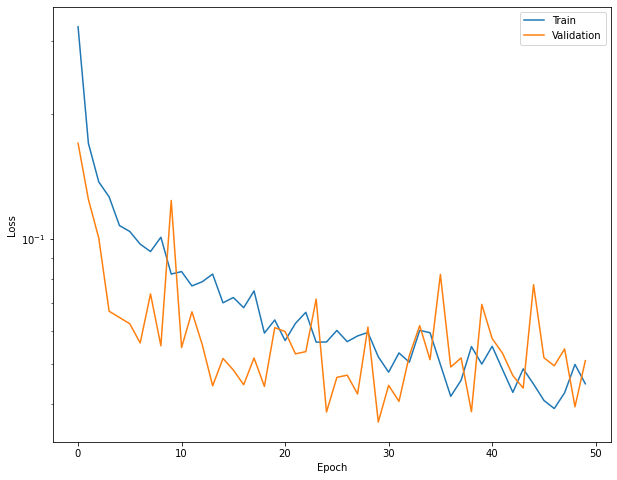

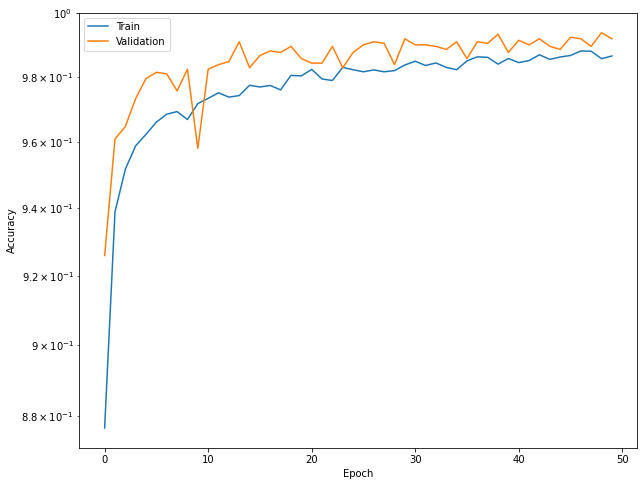

In [5]:
print("Training complete")
# Find the best fold
flag_debug=False
output_save_directory=os.path.join('checkpoints', str(N_CLASSES)+"Class", save_folder_name, 
                                      str(max_layers_to_freeze))

# AVERAGE PERFORMANCE
testl_f,tl_f,testa_f,ta_f=[],[],[],[]
k=split_k_folds
for f in range(1,k+1):
    tl_f.append(np.mean(foldperf['fold{}'.format(f)]['loss']['train']))
    testl_f.append(np.mean(foldperf['fold{}'.format(f)]['loss']['val']))

    ta_f.append(np.mean(foldperf['fold{}'.format(f)]['accuracy']['train']))
    testa_f.append(np.mean(foldperf['fold{}'.format(f)]['accuracy']['val']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Loss: {:.3f} \t Average Test Loss: {:.3f} \t Average Training Acc: {:.3f} \t Average Test Acc: {:.3f}"
      .format(np.mean(tl_f),np.mean(testl_f),np.mean(ta_f),np.mean(testa_f)))
print("Best fold: {}".format(np.argmax(testa_f)+1))

import json
save_dict = {"Loss":{"Training":np.mean(tl_f),"Validation":np.mean(testl_f)}, 
             "Accuracy":{"Training":np.mean(ta_f), "Validation":np.mean(testa_f)}}
with open(os.path.join(output_save_directory,'data.json'), 'w') as fp:
    json.dump(save_dict, fp)

# Averaging accuracy and loss
diz_ep = {'train_loss_ep':[],'test_loss_ep':[],'train_acc_ep':[],'test_acc_ep':[]}
for i in range(num_epochs):
    diz_ep['train_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['loss']['train'][i] for f in range(k)]))
    diz_ep['test_loss_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['loss']['val'][i] for f in range(k)]))
    diz_ep['train_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['accuracy']['train'][i] for f in range(k)]))
    diz_ep['test_acc_ep'].append(np.mean([foldperf['fold{}'.format(f+1)]['accuracy']['val'][i] for f in range(k)]))

# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_loss_ep'], label='Train')
plt.semilogy(diz_ep['test_loss_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.grid()
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, "average_fold_loss"+".png"))
plt.show()

# Plot accuracies
plt.figure(figsize=(10,8))
plt.semilogy(diz_ep['train_acc_ep'], label='Train')
plt.semilogy(diz_ep['test_acc_ep'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.grid()
plt.legend()
if not flag_debug:
    plt.savefig(os.path.join(output_save_directory, "average_fold_accuracy"+".png"))
plt.show()

In [6]:
print("Length of validation idx: {}".format(len(val_idx)))
len(dl_validation.sampler)

Length of validation idx: 209


209

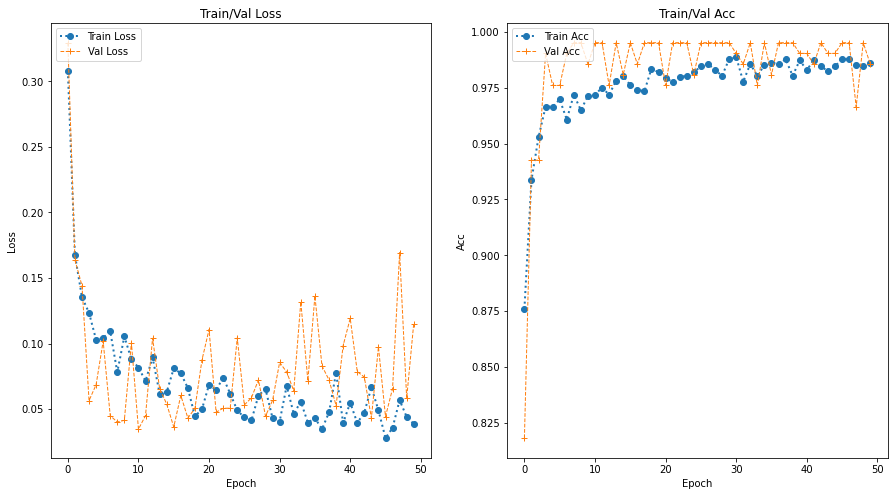

In [7]:
# Graph Visualisation
import matplotlib.pyplot as plt

epoch_list= list(i for i in range(0,num_epochs))

fig, ax = plt.subplots(1,2, figsize=(15,8))
ax[0].set(title='Train/Val Loss', xlabel='Epoch', ylabel='Loss' )
ax[0].plot(epoch_list, history["loss"]['train'],linewidth=2,linestyle=':',label='Train Loss', marker='o')
ax[0].plot(epoch_list, history["loss"]['val'], linewidth=1, linestyle='--', label='Val Loss', marker='+')
ax[0].legend(loc=2)

ax[1].set(title='Train/Val Acc', xlabel='Epoch', ylabel='Acc' )
ax[1].plot(epoch_list, history["accuracy"]['train'], linewidth=2, linestyle=':', label='Train Acc', marker='o')
ax[1].plot(epoch_list, history["accuracy"]['val'], linewidth=1, linestyle='--', label='Val Acc', marker='+')
ax[1].legend(loc=2)
plt.savefig(os.path.join(checkpoint_save_path,"lossaccpic_"+str(N_CLASSES)+"class.png"), bbox_inches='tight')

plt.show()